In [ ]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
#from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
#from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 15})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [7, 5]
#from IPython.display import Audio, display
#def allDone():
#    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
#import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
#import emcee
import corner
#import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
#from multiprocessing import Pool
#import pickle
#import h5py
#import multiprocessing
#import itertools
#from multiproessing import sharedctypes
print('imported')
import scipy

In [2]:
import pandas as pd

In [3]:
import keras.backend as K

Using TensorFlow backend.


In [4]:
import tensorflow as tf

In [5]:
from keras.models import Sequential,Model
from keras.layers import Dense,Input
from keras.optimizers import Adam, Adamax, SGD
#from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler

In [6]:
## Enter parameter:
searchparameter = '_'

prefilenames = os.listdir('koester2/')
filenames = []
for i in range(len(prefilenames)):
    if searchparameter in prefilenames[i]:
        filenames.append(prefilenames[i])
        
len(filenames)

1040

In [7]:
modelspectra = [];
modelwl = [];
loggs = [];
teffs = [];
for i in tqdm(filenames):
    specname=i
    f = open('koester2/'+specname)
    data = f.readlines()
    f.close()
    headerdata = data[0:7]
    spectraldata = data[6:]
    lam = []
    flux = []

    for i in range(len(spectraldata)):
        l=float(spectraldata[i].split()[0])
        lam.append(l)
        f = float(spectraldata[i].split()[1])
        flux.append(f)

    lam = np.asarray(lam)
    flux = np.asarray(flux) / 1e7

    teff = float(headerdata[1].split()[3])
    logg = float(headerdata[2].split()[3])
    
    in1 = find_nearest(lam,4000)
    in2 = find_nearest(lam,8000)

    flux = flux[in1:in2]
    lam = lam[in1:in2]
    
    flux = flux[:-1][~ (np.diff(lam) == 0)]
    lam = lam[:-1][~ (np.diff(lam) == 0)]
    
    lamgrid = np.arange(4000,8000)
    
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    flux = func(lamgrid)
    
    modelspectra.append(flux)
    modelwl.append(lam)
    teffs.append(teff)
    loggs.append(logg)

modelspectra = np.asarray(modelspectra)
loggs = np.asarray(loggs)
teffs = np.asarray(teffs)

100%|██████████| 1040/1040 [00:07<00:00, 132.01it/s]


In [8]:
X = np.stack((teffs,loggs)).transpose()
t = np.log(modelspectra)

sc = MinMaxScaler()
msc = StandardScaler()

X_scaled = sc.fit_transform(X)
t_scaled = msc.fit_transform(t)

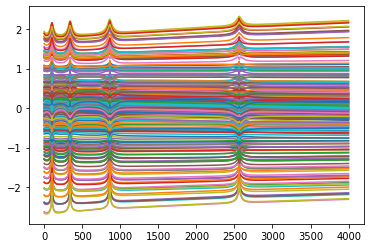

In [9]:
plt.plot(t_scaled[0:205].T);

In [20]:
H = 256
def generator():
    x = Input(shape=(X[0].shape[0],))
    y = Dense(H,activation='sigmoid')(x)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    out = Dense(4000,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
history = [];
model.load_weights('model_interp_deeper.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               768       
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 4000)              1028000   
Total params: 1,226,144
Trainable params: 1,226,144
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in tqdm(range(1000)): 
    print('Training meta-batch %i'%i)
    
    n_epochs = 100
    batch = 32
    
    h = model.fit(X_scaled,t_scaled, epochs = n_epochs, verbose = 0, batch_size = batch, shuffle = True)
    history = np.append(history, h.history['loss'])
    model.save_weights('model_interp_deeper.h5')


  0%|          | 0/1000 [00:00<?, ?it/s]

Training meta-batch 0



  0%|          | 1/1000 [01:00<16:39:37, 60.04s/it]

Training meta-batch 1



  0%|          | 2/1000 [01:59<16:37:46, 59.99s/it]

Training meta-batch 2



  0%|          | 3/1000 [02:59<16:35:12, 59.89s/it]

Training meta-batch 3



  0%|          | 4/1000 [03:59<16:34:12, 59.89s/it]

Training meta-batch 4



  0%|          | 5/1000 [04:59<16:32:40, 59.86s/it]

Training meta-batch 5



  1%|          | 6/1000 [05:59<16:31:06, 59.83s/it]

Training meta-batch 6



  1%|          | 7/1000 [06:58<16:29:00, 59.76s/it]

Training meta-batch 7



  1%|          | 8/1000 [07:58<16:28:14, 59.77s/it]

Training meta-batch 8



  1%|          | 9/1000 [08:58<16:28:13, 59.83s/it]

Training meta-batch 9



  1%|          | 10/1000 [09:57<16:24:57, 59.69s/it]

Training meta-batch 10



  1%|          | 11/1000 [10:57<16:22:17, 59.59s/it]

Training meta-batch 11



  1%|          | 12/1000 [11:56<16:21:57, 59.63s/it]

Training meta-batch 12



  1%|▏         | 13/1000 [12:56<16:21:44, 59.68s/it]

Training meta-batch 13



  1%|▏         | 14/1000 [13:56<16:21:58, 59.75s/it]

Training meta-batch 14



  2%|▏         | 15/1000 [14:56<16:20:12, 59.71s/it]

Training meta-batch 15



  2%|▏         | 16/1000 [15:55<16:19:38, 59.73s/it]

Training meta-batch 16



  2%|▏         | 17/1000 [16:55<16:18:06, 59.70s/it]

Training meta-batch 17



  2%|▏         | 18/1000 [17:54<16:15:17, 59.59s/it]

Training meta-batch 18



  2%|▏         | 19/1000 [18:54<16:15:02, 59.64s/it]

Training meta-batch 19



  2%|▏         | 20/1000 [19:54<16:15:02, 59.70s/it]

Training meta-batch 20



  2%|▏         | 21/1000 [20:54<16:14:32, 59.73s/it]

Training meta-batch 21



  2%|▏         | 22/1000 [21:53<16:11:32, 59.60s/it]

Training meta-batch 22



  2%|▏         | 23/1000 [22:52<16:09:25, 59.53s/it]

Training meta-batch 23



  2%|▏         | 24/1000 [23:52<16:07:52, 59.50s/it]

Training meta-batch 24



  2%|▎         | 25/1000 [24:52<16:07:24, 59.53s/it]

Training meta-batch 25



  3%|▎         | 26/1000 [25:51<16:08:05, 59.64s/it]

Training meta-batch 26



  3%|▎         | 27/1000 [26:50<16:02:05, 59.33s/it]

Training meta-batch 27



  3%|▎         | 28/1000 [27:50<16:02:54, 59.44s/it]

Training meta-batch 28



  3%|▎         | 29/1000 [28:49<16:03:27, 59.53s/it]

Training meta-batch 29



  3%|▎         | 30/1000 [29:49<16:03:44, 59.61s/it]

Training meta-batch 30



  3%|▎         | 31/1000 [30:49<16:02:50, 59.62s/it]

Training meta-batch 31



  3%|▎         | 32/1000 [31:48<16:01:54, 59.62s/it]

Training meta-batch 32



  3%|▎         | 33/1000 [32:48<16:01:22, 59.65s/it]

Training meta-batch 33



  3%|▎         | 34/1000 [33:48<15:59:33, 59.60s/it]

Training meta-batch 34



  4%|▎         | 35/1000 [34:47<15:57:54, 59.56s/it]

Training meta-batch 35



  4%|▎         | 36/1000 [35:47<15:56:45, 59.55s/it]

Training meta-batch 36



  4%|▎         | 37/1000 [36:46<15:55:47, 59.55s/it]

Training meta-batch 37



  4%|▍         | 38/1000 [37:46<15:54:41, 59.54s/it]

Training meta-batch 38



  4%|▍         | 39/1000 [38:45<15:52:43, 59.48s/it]

Training meta-batch 39



  4%|▍         | 40/1000 [39:45<15:53:48, 59.61s/it]

Training meta-batch 40



  4%|▍         | 41/1000 [40:44<15:50:58, 59.50s/it]

Training meta-batch 41


100.000 percent improvement


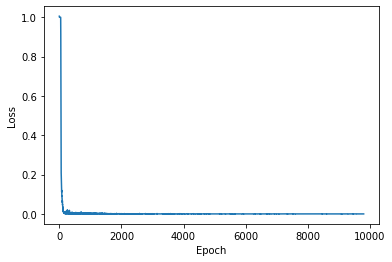

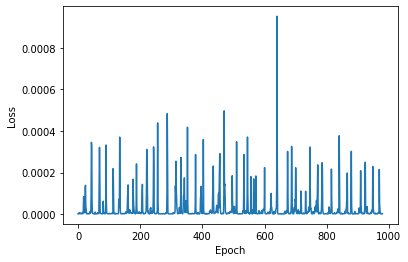

In [13]:
plt.figure()
plt.plot(history);
plt.xlabel('Epoch')
plt.ylabel('Loss')

r = int(len(history)/10)
plt.figure()
plt.plot(history[-r:]);
plt.xlabel('Epoch')
plt.ylabel('Loss')
print('%.3f percent improvement'%(100*(history[0] - history[-1])/history[0]))

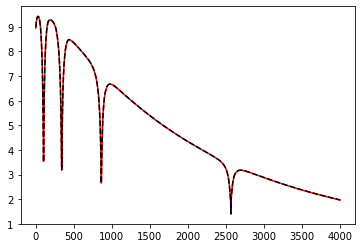

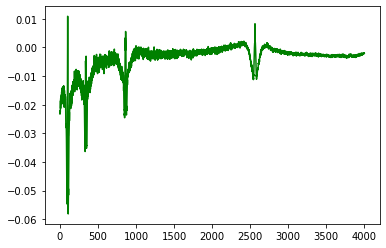

In [16]:
n = np.random.randint(0,len(X))
label = X_scaled[n].reshape(1,-1)
true = np.exp(t[n])
pred = np.exp(msc.inverse_transform(model.predict(label)))[0,:]
plt.plot(true,'k--',zorder=8)
plt.plot(pred,'r-')
plt.figure()
plt.plot(pred-true,'g-')

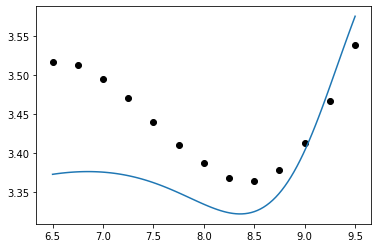

In [19]:
pixel = 2563
temp = 15000


ts = teffs[teffs == temp]
ls = loggs[teffs == temp]
labels = np.stack((ts,ls)).T
tflux = np.exp(t)[teffs == temp][:,pixel]

plt.scatter(ls,tflux,color='k')

linls = np.linspace(min(ls),max(ls),100)
lints = np.repeat(temp,100)
linlabels = np.stack((lints,linls)).T
lintflux = np.exp(msc.inverse_transform(model.predict(sc.transform(linlabels))))[:,pixel]
plt.plot(linls,lintflux)

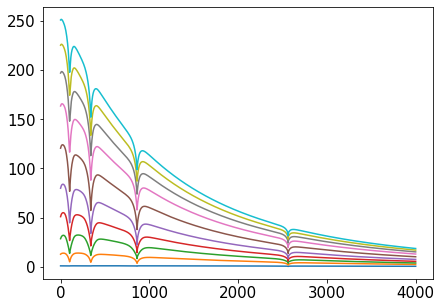

In [459]:
n = 10
ls = np.linspace(8,8,n)
ts = np.linspace(6000,50000,n)
labels = np.stack((ts,ls)).T
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(labels))))
for i in preds:
    plt.plot(i)

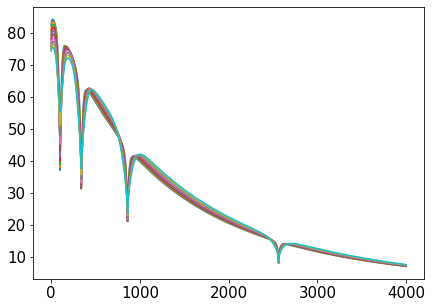

In [432]:
n = 10
ls = np.linspace(6.5,9.5,n)
ts = np.linspace(25000,25000,n)
labels = np.stack((ts,ls)).T
preds = np.exp(msc.inverse_transform(model.predict(sc.transform(labels))))
for i in preds:
    plt.plot(i)

In [460]:
def ch_cont(array):
    spec = array
    lamgrid = np.linspace(4000,8000,4000)
    p = np.polynomial.chebyshev.chebfit(lamgrid,spec,4)
    contcorr = spec / np.polynomial.chebyshev.chebval(lamgrid,p)
    plt.plot(contcorr)
    return contcorr

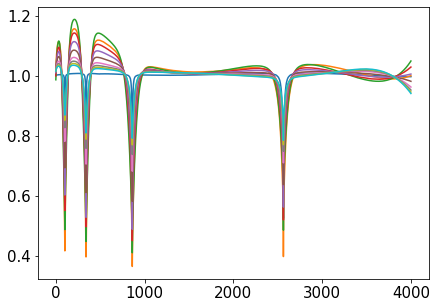

In [461]:
cpreds = [];
diffs = np.repeat(0,4000)
for i in range(len(preds)):
    cpreds.append(ch_cont(preds[i]))
cpreds = np.asarray(cpreds)

In [470]:
contbool = (np.ptp(cpreds,0) < 0.04)

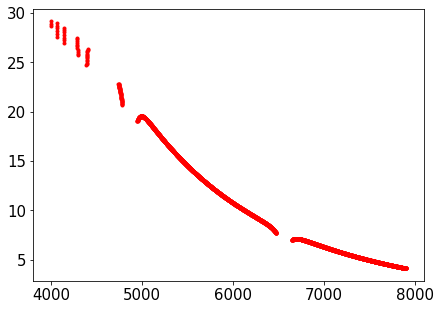

In [479]:
plt.plot(lamgrid[contbool],preds[2][contbool],'r.')